In [1]:
from Helpers import *

In [41]:
def Linearization(dt,x):
    ts,os,taus,te,oe,taue= x[:6]
    K = 1/0.06
    C = np.array([-x[4]*(2*x[1]+x[4])*a2*np.sin(x[3]),x[1]*x[1]*a2*np.sin(x[3])])
    
    dCdte = np.array([-x[4]*(2*x[1]+x[4])*a2*np.cos(x[3]),x[1]*x[1]*a2*np.cos(x[3])])
    dCdos = np.array([-x[4]*2*a2*np.sin(x[3]),2*x[1]*a2*np.sin(x[3])])
    dCdoe = np.array([(-2*x[1]-2*x[4])*a2*np.sin(x[3]),0])
    
    
    DetM = a1*a3-a3*a3-a2*a2*cos(te)*cos(te)
    Minv = np.array([[a3,-a3-a2*cos(te)],
              [-a3-a2*cos(te),a1+2*a2*cos(te)]])/DetM
    dM = np.array([[-2*a2*sin(te),-a2*sin(te)],[-a2*sin(te),0]])
    vel = np.array([np.zeros(2),(-Minv@(dCdos+Bdyn@np.array([1,0]))),Minv@np.array([1,0]),-Minv@(dM@Minv@(np.array([taus,taue]-C-Bdyn@np.array([os,oe])))+dCdte),-Minv@(dCdoe+Bdyn@np.array([0,1])),Minv@np.array([0,1]),np.zeros(2),np.zeros(2)])
    print(vel.T@x)
    A = np.array([[0,1,0,0,0,0,0,0],vel[:,0],[0,0,-K,0,0,0,0,0],[0,0,0,0,1,0,0,0],vel[:,1],[0,0,0,0,0,-K,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0]])
    A = np.identity(8)+dt*A
    
    return A

def myf(x):
    C = np.array([-x[4]*(2*x[1]+x[4])*a2*np.sin(x[3]),x[1]*x[1]*a2*np.sin(x[3])])
    M = np.array([[a1+2*a2*cos(x[3]),a3+a2*cos(x[3])],[a3+a2*cos(x[3]),a3]])
    print(np.linalg.solve(M,np.array([x[2],x[5]])-C-Bdyn@np.array([x[1],x[4]])))

x=np.array([pi/2,0.1,0,0.7,0,0,0,0])
Linearization(0.01,x)
myf(x)

[-0.2882844   0.24069969]
[-0.43193287  0.72189017]


In [3]:
dt = 0.01
print(Linearization(.01,np.array([pi/4,0,0,pi/2,0,0,0,0]))-np.array([[1,dt,0,0,0,0,0,0],[0,1+dt*(-0.5*a3+0.025*a3)/((a1-a3)*a3),dt*a3/((a1-a3)*a3),0,dt*(-0.025*a3+0.5*a3)/((a1-a3)*a3),dt/(a3-a1),0,0],
     [0,0,1-dt/tau,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,dt*(0.5*a3-0.025*a1)/((a1-a3)*a3),-dt/(a1-a3),0,1+dt*(0.025*a3-0.5*a1)/(a3*(a1-a3)),a1*dt/(a3*(a1-a3)),0,0],
     [0,0,0,0,0,1-dt/tau,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]]))

[0. 0.]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -6.93889390e-18  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000

In [45]:

def BestLQG(Duration = .6,w1 = 1e7,w2 = 1e7,w3 = 1e3,w4 = 1e3,r1 = 1e-5,r2 = 1e-5,targets = [0,55],starting_point = [0,20],FF = False,Side = "Right",plot = True,Delay = 0,newtonfunc = newtonf,newtondfunc = newtondf,Num_iter = 300,Activate_Noise = False,plotEstimation = False,MultipleLinearization = False):


    
    dt = Duration/Num_iter
    kdelay = int(Delay/dt)

    obj1,obj2 = newton(newtonfunc,newtondfunc,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(newtonfunc,newtondfunc,1e-8,1000,starting_point[0],starting_point[1])

    xstart = np.array([st1,0,0,st2,0,0,obj1,0,obj2,0])
    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    x0_with_delay = np.copy(x0)
    for _ in range(kdelay):
        x0_with_delay = np.concatenate((x0_with_delay,x0))
    Num_Var = 8
    
    #Define Weight Matrices

    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w2,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
             [0,0,0,w3,0,0,0,-w3],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
             [-w1,0,0,0,0,0,w1,0],[0,0,0,-w3,0,0,0,w3]])
    
    
    #Define Dynamic Matrices  

    

    B_basic = np.transpose([[0,0,dt/tau,0,0,0,0,0],[0,0,0,0,0,dt/tau,0,0]])

    NewQ = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    NewQ[:Num_Var,:Num_Var] = Q 
    Q = NewQ

    H = np.zeros((Num_Var,(kdelay+1)*Num_Var))
    H[:,(kdelay)*Num_Var:]= np.identity(Num_Var)

    A = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    
    A[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    B = np.zeros(((kdelay+1)*Num_Var,2))
    B[:Num_Var] = B_basic
    
    

    
    array_L = np.zeros((Num_iter-1,2,Num_Var*(kdelay+1)))   
    array_S = np.zeros((Num_iter,Num_Var*(kdelay+1),Num_Var*(kdelay+1))) 
    array_S[-1] = Q

        
    array_x = np.zeros((Num_iter,Num_Var))
    array_xhat = np.zeros((Num_iter,Num_Var))
    y = np.zeros((Num_iter-1,Num_Var))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()
    array_u = np.zeros((Num_iter-1,2))
    xhat = np.copy(x0_with_delay)
    x = np.copy(x0_with_delay)

    sigma = np.identity(Num_Var*(kdelay+1))*10**-6 
    J = 0
    F = [0,0]
    omega = np.zeros(2)
    for k in range(Num_iter-1):
        linpoint = x[:8] if MultipleLinearization else [pi/2,0,0,pi/4,0,0,0,0]
        A[:Num_Var,:Num_Var] = Linearization(dt,linpoint)
        if k==0:
            AKalman = np.copy(A)
        S = Q
        for l in range(Num_iter-1):
            L = np.linalg.inv(R+B.T@S@B)@B.T@S@A
            array_L[Num_iter-2-l] = L
            S = A.T@S@(A-B@L)
            array_S[Num_iter-2-l] = S
            
        #print(array_L[0])
        #Feedback
        L=array_L
        
        C = np.array([-x[4]*(2*x[1]+x[4])*a2*np.sin(x[3]),x[1]*x[1]*a2*np.sin(x[3])])
        
        M = np.array([[a1+2*a2*cos(x[3]),a3+a2*cos(x[3])],[a3+a2*cos(x[3]),a3]])
        #acc = np.linalg.solve(M,(np.array([x[2],x[5]])-Bdyn@np.array([x[1],x[4]])-C))+F
        acc = (np.array([array_x[k][2],array_x[k][5]])-np.array([array_x[k-1][2],array_x[k-1][5]]))/dt
        if (np.sin(x[0]+x[3])*33+np.sin(x[0])*30 > 35) and (FF == True):

            F = Compute_f_new_version(np.array([x[0],x[3]]),np.array([x[1],x[4]]),acc,.3)
            if Side == "Left": F*=-1

        else : 
            F = np.array([0,0])
        Omega_sens,Omega_measure,motor_noise,measure_noise = NoiseAndCovMatrix(M,Num_Var,kdelay,Linear=True)
        y[k] = (H@x).flatten()
        if Activate_Noise == True : y[k]+=measure_noise
        K = AKalman@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (AKalman - K@H)@sigma@AKalman.T
        u = - L[k].reshape(np.flip(B.shape))@xhat
        array_u[k] = u
        J+= u.T@R@u
        xhat = A@xhat + B@u + K@(y[k]-H@xhat)
        Kfactor = 1/0.06
        omega += dt*np.linalg.solve(M,np.array([x[2],x[5]])-C-Bdyn@omega)+dt*F
        x = np.concatenate((np.array([x[0]+dt*x[1],omega[0],x[2]+dt*Kfactor*(u[0]-x[2]),x[3]+dt*x[4],omega[1],x[5]+dt*Kfactor*(u[1]-x[5]),x[6],x[7]]),x[:-Num_Var]))

        if Activate_Noise : 
            x[2]+=motor_noise[0]
            x[5]+=motor_noise[1]
        array_xhat[k+1] = xhat[:Num_Var].flatten()
        array_x[k+1] = x[:Num_Var].flatten()

        #print(array_x[k-1,2],((array_x[k]-array_x[k-1])/dt)[1])   

#Plot
    J+= x.T@Q@x
    x0 = xstart
    
    x_nonlin = array_x.T[:,:][:,::1]
    X = np.cos(x_nonlin[0]+x_nonlin[3])*33+np.cos(x_nonlin[0])*30
    Y = np.sin(x_nonlin[0]+x_nonlin[3])*33+np.sin(x_nonlin[0])*30

    if plot:
        plt.plot(X,Y,color = "green",label = "LQG",linewidth = .8)
        plt.axis("equal")
        plt.scatter([targets[0]],[targets[1]],color = "black")
        if plotEstimation :
            x_nonlin = array_xhat.T[:,1:][:,::1]
            X2 = np.cos(x_nonlin[0]+x_nonlin[3])*33+np.cos(x_nonlin[0])*30
            Y2 = np.sin(x_nonlin[0]+x_nonlin[3])*33+np.sin(x_nonlin[0])*30
            plt.plot(X2,Y2,color = "black",label = "Estimation",linewidth = .8,linestyle ="--",alpha = .5)
    return X,Y,array_u,x_nonlin

[0. 0.]
[2.92842446 0.05171391]
[ 4.75169078 -0.54368627]
[ 5.98100748 -1.39914821]
[ 6.89757268 -2.27084344]
[ 7.63293522 -3.01336051]
[ 8.23777137 -3.54060163]
[ 8.72619231 -3.8033787 ]
[ 9.09966889 -3.78085758]
[ 9.35862081 -3.47909942]
[ 9.50735836 -2.93155595]
[ 9.55552015 -2.19841083]
[ 9.51756043 -1.36314224]
[ 9.41101792 -0.52563511]
[9.25395828 0.20820837]
[9.06193464 0.73992734]
[8.84482461 0.99401504]
[8.60406091 0.93371663]
[8.33096562 0.57435813]
[ 8.00707341 -0.00954085]
[ 7.60733303 -0.68762437]
[ 7.10665634 -1.29101288]
[ 6.48930713 -1.64424042]
[ 5.75913525 -1.60754007]
[ 4.94722763 -1.11937686]
[ 4.11304487 -0.22521167]
[3.33633798 0.92045812]
[2.70014178 2.08438353]
[2.26890024 3.01124606]
[2.06857303 3.49005805]
[2.07609609 3.40855942]
[2.22329282 2.77690235]
[2.41596819 1.71156219]
[2.56374339 0.3828252 ]
[ 2.61252517 -1.06041776]
[ 2.5701888  -2.56974195]
[ 2.5183304  -4.26236985]
[ 2.60402642 -6.45642472]
[ 2.99525463 -9.64150503]
[  3.73890542 -14.25324749]
[  4

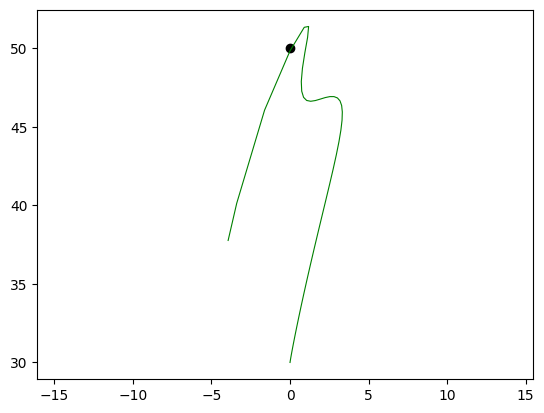

In [46]:
x,y,u,z=BestLQG(Duration=.4,Num_iter=50,starting_point=[0,30],targets=[0,50],MultipleLinearization=True)

(50, 6)
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


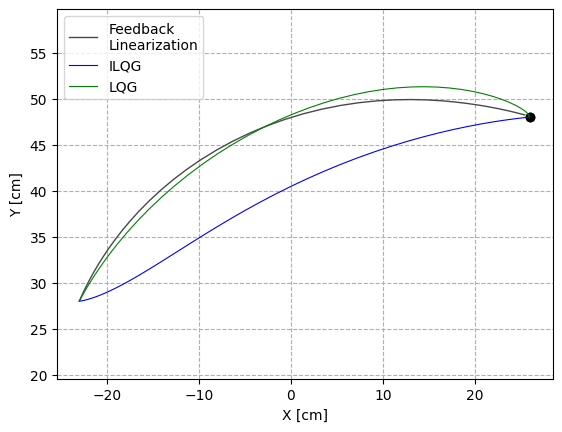

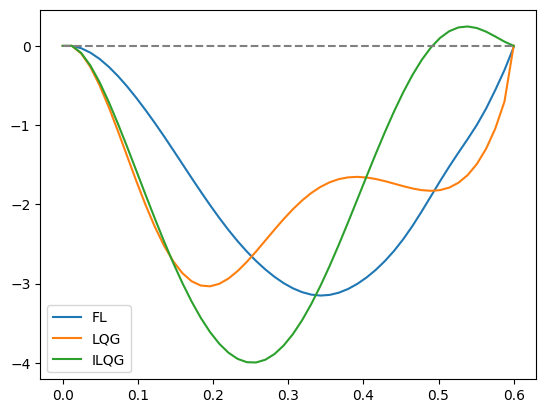

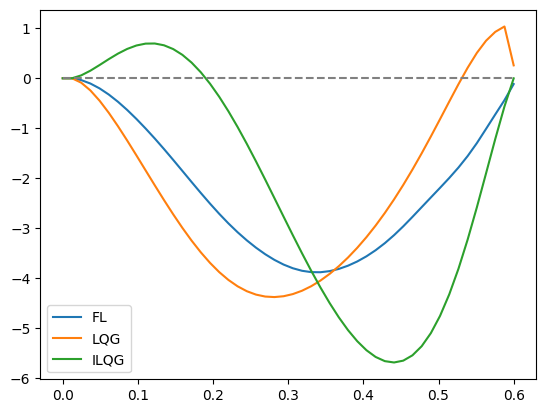

In [6]:
from ILQGController import *
from FLController import *

x,y,j,xfl = Feedback_Linearization(Duration=.4,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=50,starting_point=[-23,28],targets=[26,48],ShowJ=True)
x,y,u,zilqg=ILQG(.4,1e7,1e3,1e-5,[26,48],50,[-23,28])
print(zilqg.shape)
x,y,u,z=BestLQG(Duration=.4,Num_iter=50,starting_point=[-23,28],targets=[26,48])
plt.legend()
plt.show()

plt.plot(np.linspace(0,.6,50),xfl[:,2],label="FL")
plt.plot(np.linspace(0,.6,50),z[1],label = "LQG")
plt.plot(np.linspace(0,.6,50),zilqg[:,2],label = "ILQG")
plt.plot(np.linspace(0,.6,60),np.zeros(60),color = "grey",linestyle = "--")
plt.legend()
plt.show()

plt.plot(np.linspace(0,.6,50),xfl[:,3],label="FL")
plt.plot(np.linspace(0,.6,50),z[4],label = "LQG")
plt.plot(np.linspace(0,.6,50),zilqg[:,3],label = "ILQG")
plt.plot(np.linspace(0,.6,60),np.zeros(60),color = "grey",linestyle = "--")
plt.legend()
#x,y,u=BestLQG(Duration=.6,Num_iter=120,MultipleLinearization=True)

(50, 6)
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


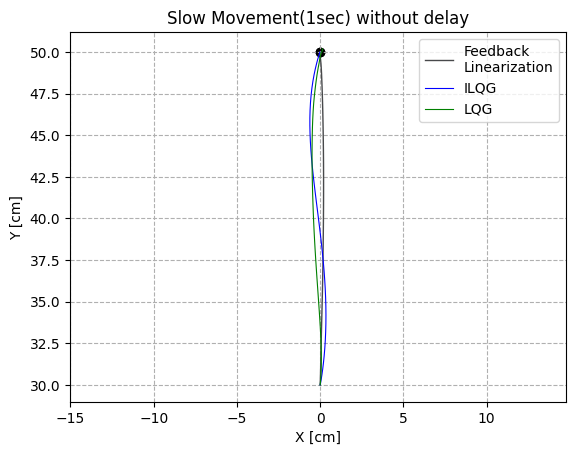

(50, 6)
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


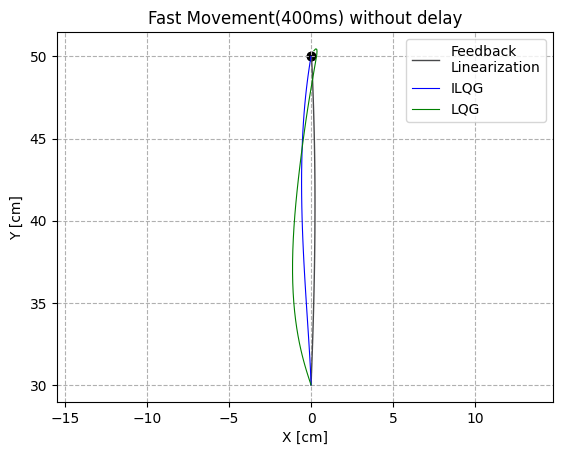

(50, 24)
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


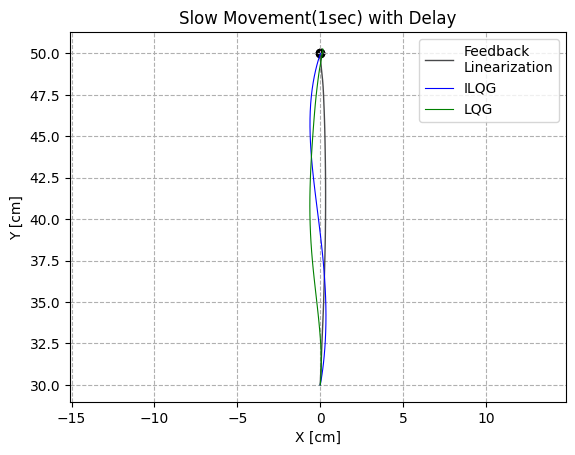

(50, 48)
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


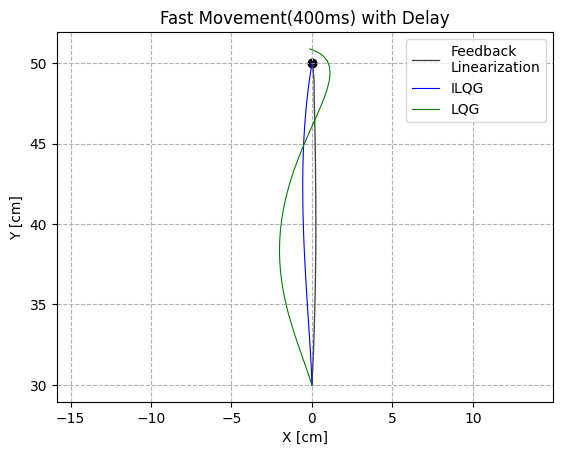

In [7]:
from ILQGController import *
from FLController import *
for Delay in [0,0.06]:
    for Duration in [1,.4]:
        x,y,j,xfl = Feedback_Linearization(Duration=Duration,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=50,starting_point=[0,30],targets=[0,50],ShowJ=True,Activate_Noise=True,Delay=Delay)
        x,y,u,zilqg=ILQG(Duration,1e7,1e3,1e-5,[0,50],50,[0,30],Noise=True,Delay=Delay)
        print(zilqg.shape)
        x,y,u,z=BestLQG(Duration=Duration,Num_iter=50,starting_point=[0,30],targets=[0,50],Activate_Noise=True,Delay=Delay)
        plt.legend()
        title1 = "Slow Movement(1sec)" if Duration == 1 else "Fast Movement(400ms)"
        title2 = " without delay" if Delay == 0 else " with Delay"
        plt.title(title1+title2)
        plt.show()
    #x,y,u=BestLQG(Duration=.6,Num_iter=120,MultipleLinearization=True)

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


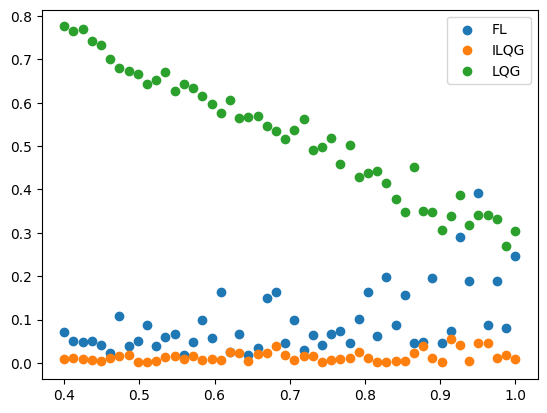

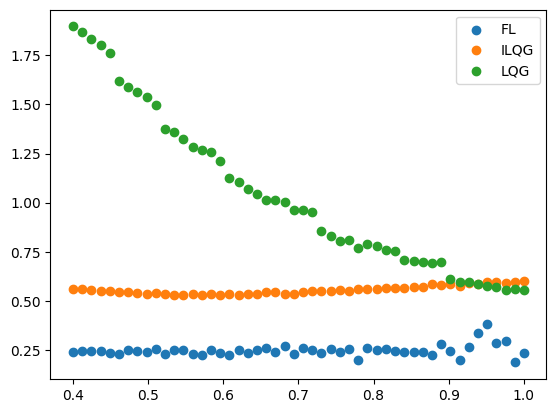

In [8]:
from ILQGController import *
from FLController import *

Delay = .06
Error = np.zeros((6,50))
D = np.linspace(0.4,1,50)
for i,Duration in enumerate(D):
        x,y,j,xfl = Feedback_Linearization(Duration=Duration,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=60,starting_point=[0,30],targets=[0,50],ShowJ=True,Activate_Noise=True,Delay=Delay,plot = False)
        Error[0,i] = np.sqrt((x[-1])**2+(y[-1]-50)**2)
        Error[3,i] = np.max(np.abs(x))
        x,y,u,zilqg=ILQG(Duration,1e7,1e3,1e-5,[0,50],60,[0,30],Noise=True,Delay=Delay,plot = False)
        Error[1,i] = np.sqrt((x[-1])**2+(y[-1]-50)**2)
        Error[4,i] = np.max(np.abs(x))
        x,y,u,z=BestLQG(Duration=Duration,Num_iter=60,starting_point=[0,30],targets=[0,50],Activate_Noise=True,Delay=Delay,plot = False)
        Error[2,i] = np.sqrt((x[-1])**2+(y[-1]-50)**2)
        Error[5,i] = np.max(np.abs(x))

LABELS = ["FL","ILQG","LQG"]
for i in range(3):
        plt.scatter(D,Error[i],label = LABELS[i])
plt.legend()
plt.show()

for i in range(3,6):
        plt.scatter(D,Error[i],label = LABELS[i-3])
plt.legend()
plt.show()

(50, 6)
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


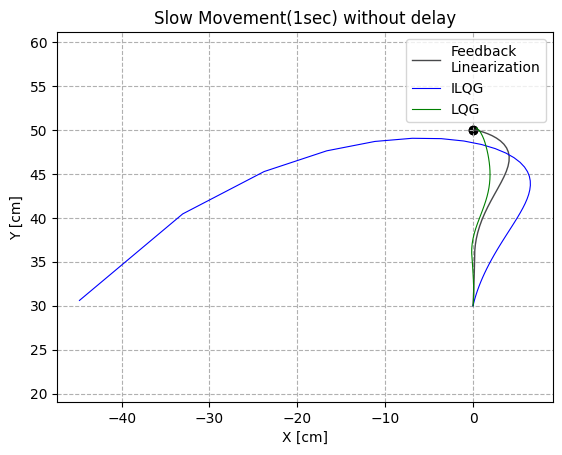

(50, 6)
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


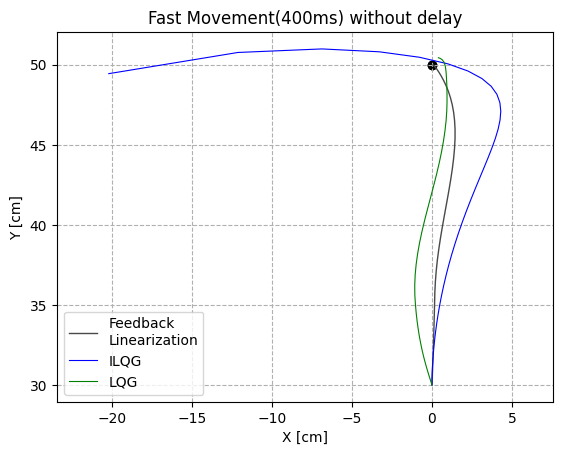

(50, 24)
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


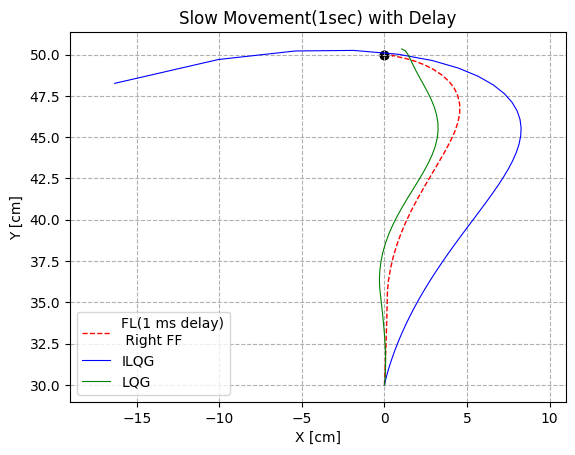

(50, 48)
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


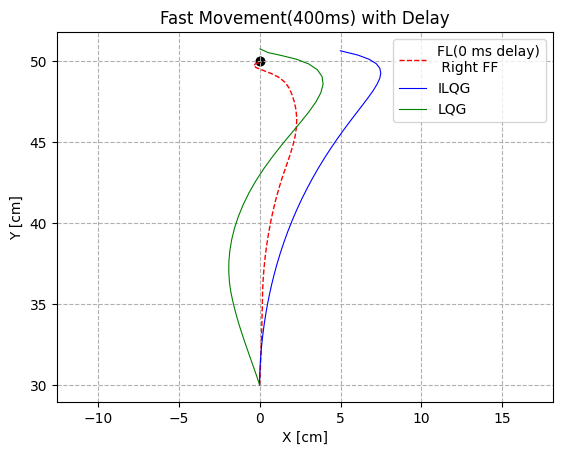

In [9]:
from ILQGController import *
from FLController import *
for Delay in [0,0.06]:
    for Duration in [1,.4]:
        x,y,j,xfl = Feedback_Linearization(Duration=Duration,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=50,starting_point=[0,30],targets=[0,50],ShowJ=True,Activate_Noise=True,Delay=Delay,AdditionalDynamics={"FF":True,"FFonset":35,"Side":"Right"})
        x,y,u,zilqg=ILQG(Duration,1e7,1e3,1e-5,[0,50],50,[0,30],Noise=True,Delay=Delay,FF=True,Side="Right")
        print(zilqg.shape)
        x,y,u,z=BestLQG(Duration=Duration,Num_iter=50,starting_point=[0,30],targets=[0,50],Activate_Noise=True,Delay=Delay,FF=True)
        plt.legend()
        title1 = "Slow Movement(1sec)" if Duration == 1 else "Fast Movement(400ms)"
        title2 = " without delay" if Delay == 0 else " with Delay"
        plt.title(title1+title2)
        plt.show()